# Спууки автори

[Линк към дейтасета](https://www.kaggle.com/c/spooky-author-identification/data)

# Зареждане на малко библиотеки

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import networkx as nx

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [23]:
# Loading the data
train = pd.read_csv('data/spooky-train.zip', index_col='id')
test = pd.read_csv('data/spooky-test.zip', index_col='id')

full_data = [train, test]

# Lets have a look at the data
train.sample(5)

,text,author
id,,
id25346,The stones in the crumbling corridors seemed a...,HPL
id24785,"But, as it is my design never to return or not...",EAP
id02675,But they were ever together and their happines...,MWS
id07404,He resolved to drag the burthen the evidence g...,EAP
id00982,"But when questioned, Slater relapsed into the ...",HPL


# Разглеждане на дейтасета

In [7]:
train.describe()

,text,author
count,19579,19579
unique,19579,3
top,"If, dating our inquiries from the body found, ...",EAP
freq,1,7900


In [19]:
train['text'].apply(lambda t: len(t)).describe()

count    19579.000000
mean       149.057408
std        106.800189
min         21.000000
25%         81.000000
50%        128.000000
75%        191.000000
max       4663.000000
Name: text, dtype: float64

In [20]:
train['text'].apply(lambda t: len(t.split(' '))).describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: text, dtype: float64

*Текстовете не са много дълги. Имаме средно по:*
 - 150 символа
 - 25 думи

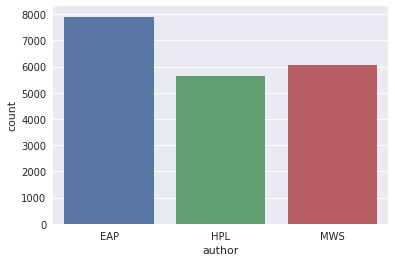

In [62]:
sns.countplot(data=train, x='author');

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19579 entries, id26305 to id00393
Data columns (total 2 columns):
text      19579 non-null object
author    19579 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


In [22]:
train.isnull().sum()

text      0
author    0
dtype: int64

 - Нямаме прази клетки
 - Имаме само текстови полета
 - Класовете са 3 на брой

# Малко помагачи за енкодване

In [54]:
class StringOneHotEncoder(LabelBinarizer):
    def __init__(self, prefix='col', key=lambda x: x, **kwargs):
        self.prefix = prefix
        self.key = key
        super(StringOneHotEncoder, self).__init__(**kwargs)
    
    def map_input(self, y):
        return y

    def fit(self, y, prefix='col', key=lambda x: x):
        self.key = key
        return super(StringOneHotEncoder, self).fit(self.map_input(y))

    def transform(self, y):
        cols = list(map(lambda s: self.prefix + '_' + s, self.classes_))
        if len(cols) == 2:
            cols = [self.prefix]
        result = pd.DataFrame(super(StringOneHotEncoder, self).transform(self.map_input(y)), columns=cols)
        result.index += 1
        return result
        
    def fit_transform(self, y, *_):
        self.fit(y)
        return self.transform(y)

Този клас one-hoy encode-ва стрингове, уау!

# Векторизатори и класификатори

In [46]:
X_train_text = train['text']
y_train_author = train['author']

X_test_text = test['text']

In [42]:
cv = CountVectorizer(lowercase=True, token_pattern=r'\w+|\,')

cv.fit(X_train_text)
X_train_cv = cv.transform(X_train_text)
X_test_cv = cv.transform(X_test_text)

In [43]:
print(X_train_cv.shape, X_test_cv.shape)

(19579, 25096) (8392, 25096)


In [58]:
author_encoder = StringOneHotEncoder()
author_encoder.fit(y_train_author)

y_train_one_hot = author_encoder.transform(y_train_author)
y_train_one_hot.head(5)

,col_EAP,col_HPL,col_MWS
1,1,0,0
2,0,1,0
3,1,0,0
4,0,0,1
5,0,1,0


In [60]:
y_train_one_hot.shape

(19579, 3)

In [78]:
linear_model = LinearSVC()

In [79]:
cross_val_score(linear_model, X_train_cv, train['author'], cv=3, n_jobs=3)

array([ 0.7890625 ,  0.79619982,  0.79800766])

Слабо, да пробваме с нормализиран countvectorizer (TfidfVectorizer) и MultinomialNB.

In [80]:
pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.8, lowercase=False)),
    ('clf', MultinomialNB(alpha=0.01))
])

In [81]:
print(cross_val_score(pipeline, train['text'], train['author'], cv=3, n_jobs=3))

[ 0.83195466  0.83466135  0.83187739]


In [89]:
def generate_ngrams(text, n=2):
    words = text.split()
    iterations = len(words) - n + 1
    for i in range(iterations):
        yield words[i:i + n]

In [92]:
ngrams_eap_df = generate_ngrams(train['text'][train['author'] == 'EAP'])

In [93]:
trigram_df = pd.concat([ngrams_eap_df.sort_values(by='count', ascending=False).head(20),
                        ngrams_hpl_df.sort_values(by='count', ascending=False).head(20),
                        ngrams_mws_df.sort_values(by='count', ascending=False).head(20)])

AttributeError: 'generator' object has no attribute 'sort_values'

In [94]:
g = nx.from_pandas_dataframe(ngrams_eap_df,source='author',target='index')
print(nx.info(g))

AttributeError: 'generator' object has no attribute 'columns'

In [82]:
plt.figure(figsize=(20, 20))
cmap = plt.cm.coolwarm
colors = [n for n in range(len(g.nodes()))]
#k = 0.0319
k = 0.14
pos=nx.spring_layout(g, k=k)
nx.draw_networkx(g,pos, node_size=trigram_df['count'].values*150, cmap = cmap, 
                 node_color=colors, edge_color='grey', font_size=15, width=2, alpha=1)
plt.title("Network diagram of Top 20 Trigrams w/o Stopwords removed attributed to each Author",
         fontsize=18)
plt.show()

NameError: name 'g' is not defined